In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import shutil
import IPython
import IPython.display as ipd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import librosa
from scipy.io import wavfile
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
from pathlib import Path
import torch
from fastai import *
from fastai.dataset import *
from fastai.learner import *
from fastai.text import *
from shutil import copyfile
from operator import itemgetter


%matplotlib inline
matplotlib.style.use('ggplot')
# torch.cuda.set_device(0)

/Users/blakewest/anaconda/envs/fastaudio/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
DATA_PATH = Path('./data/freesound')
TRN_PATH = Path('./data/freesound/audio_train')
# TEST_PATH = Path('./data/freesound/audio_test')
LABEL_PATH = Path('./data/freesound/train.csv')
# SAMPLE_SUBMISSION_PATH = Path('./data/freesound/sample_submission.csv')

In [3]:
train = pd.read_csv(LABEL_PATH)

FileNotFoundError: File b'data/freesound/train.csv' does not exist

In [17]:
class BasicAudioModel(nn.Module):
    def __init__(self, num_classes, bs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 16, 9),
            nn.ReLU(),
            nn.Conv1d(16, 16, 9),
            nn.ReLU(),
            nn.MaxPool1d(16),
            nn.Dropout(0.1),
            nn.Conv1d(16, 32, 3),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(8),
            nn.Dropout(0.01),
            nn.Conv1d(32, 256, 3),
            nn.ReLU(),
            nn.Conv1d(256, 256, 3),
            nn.Dropout(0.01),
            nn.MaxPool1d(4),
            nn.Conv1d(256, num_classes, 3),
            Lambda(lambda tensor: torch.mean(tensor, 2, keepdim=True)),
            Lambda(lambda tensor: tensor.view(tensor.shape[0], -1)),
        )

    def forward(self, input):
        return self.model(input)

def get_trn_val_split(x, y, val_pct=0.15):
    val_idxs = get_cv_idxs(len(x), val_pct=val_pct)
    if isinstance(x, list):
        return [([arr[i] for i in val_idxs], [arr[i] for i in range(len(arr)) if i not in val_idxs]) for arr in [x,y]]
    else:
        return split_by_idx(val_idxs, x, y)

class AudioLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data):
        return F.cross_entropy

def load_audio_from_df(trn_path, trn_df, sample_rate=16000):
    return [retrieve_file(str(trn_path) + '/' + trn_df['fname'][i], sample_rate=sample_rate) for i in range(len(trn_df))]

def retrieve_file(filepath, sample_rate=16000):
    data, _ = librosa.core.load(filepath, sr=sample_rate, res_type='kaiser_fast')
    return data

def preprocess_audio(audio_files):
    norm = librosa.util.normalize
    trimmed_xs = [librosa.effects.trim(norm(x))[0] for x in audio_files]
    return [x.reshape(1, x.shape[0]) for x in trimmed_xs]

def preprocess_ys(labels, one_hot=False):
    if isinstance(labels[0], str):
        tok2int = {v:k for k,v in enumerate(np.unique(labels))}
        labels = np.array([tok2int[tok] for tok in labels])
    num_classes = len(np.unique(labels))
    if one_hot:
        return [one_hot(labels[i], num_classes).reshape(1, num_classes) for i in range(len(labels))]
    else:
        return labels

class AudioModelData():
    def __init__(self, path, trn_ds, val_ds, test_ds=None, bs=64, sample_rate=16000):
        self.path = path
        self.bs = bs
        self.trn_ds, self.val_ds, self.test_ds = trn_ds, val_ds, test_ds
        self.trn_dl = AudioDataLoader(trn_ds, bs, sampler=SortishSampler(trn_ds, key=lambda x: len(trn_ds[x][0][0]), bs=bs))
        self.val_dl = AudioDataLoader(val_ds, bs, sampler=SortishSampler(val_ds, key=lambda x: len(val_ds[x][0][0]), bs=bs))
        self.test_dl = AudioDataLoader(test_ds, bs, sampler=SortishSampler(test_ds, key=lambda x: len(test_ds[x][0][0]),bs=bs)) if test_ds is not None else None
        self.num_classes = self.trn_dl.dataset.get_c()

    @classmethod
    def from_path_and_dataframes(cls, trn_path, trn_df, test_path=None, test_df=None, val_path=None, val_df=None, val_pct=0.15, model_path='./', bs=64):
        xs = load_audio_from_df(trn_path, trn_df)
        xs = preprocess_audio(x)
        ys = preprocess_ys(trn_df['label'])
        if test_path is not None:
            text_xs = load_audio_from_df(test_path, test_df)
            text_xs = preprocess_audio(test_xs)
        else:
            test_x = None
        return cls.from_array(xs, ys, test_xs, bs=bs)

    @classmethod
    def from_array(cls, trn_x, trn_y, test_x=None, val_pct=0.15, bs=64, model_path="./", **kwargs):
        ((val_x, trn_x), (val_y, trn_y)) = get_trn_val_split(trn_x, trn_y, val_pct)
        trn_ds = AudioDataset(trn_x, trn_y)
        val_ds = AudioDataset(val_x, val_y)
        test_ds = AudioDataset(test_x, test_y) if test_x is not None else None
        return cls(model_path, trn_ds, val_ds, test_ds, bs=bs)

    def get_model(self, optimizer=torch.optim.Adam):
        basic_model = BasicAudioModel(self.num_classes, self.bs)
        model = SingleModel(to_gpu(basic_model))
        return AudioLearner(self, model, opt_fn=optimizer)

class AudioDataLoader(DataLoader):
    def get_batch(self, indexes):
        batch_data = [self.dataset[i] for i in indexes]
        x_lens = [len(item[0][0]) for item in batch_data]
        if len(np.unique(x_lens)) > 1:
            max_len = np.max(x_lens)
            for i, item in enumerate(batch_data):
                item = list(item)
                clip_len = len(item[0][0])
                item[0] = np.pad(item[0], ((0,0), (0, max_len-clip_len)), 'wrap')
                batch_data[i] = tuple(item)
        return self.np_collate(batch_data)
    
class AudioDataLoader(DataLoader):
    def get_batch(self, indexes):
        batch_data = [self.dataset[i] for i in indexes]
        x_lens = [item[0].shape[1] for item in batch_data]
        if len(np.unique(x_lens)) > 1:
            max_len = np.max(x_lens)
            for i, item in enumerate(batch_data):
                x, y = item
                clip_len = x.shape[1]
                pad_mode = 'wrap' if clip_len > 1 else 'constant'
                x = np.pad(x, ((0, 0), (0, max_len-clip_len)), pad_mode)
                batch_data[i] = x, y
        return self.np_collate(batch_data)

class AudioDataset(BaseDataset):
    def __init__(self, xs, ys, transforms=None):
        if isinstance(ys[0], str):
            ys = preprocess_ys(ys)
        self.ys = ys
        self.xs = xs
        assert(len(xs) == len(ys)), "Length of xs does not equal length of ys"
        super().__init__(transforms)

    def get_x(self, i):
        return self.xs[i]

    def get_y(self, i):
        return self.ys[i]

    def get_n(self):
        return len(self.xs)

    def get_sz(self):
        return self.get_x(1).shape[0]

    def get_c(self):
        return int(np.max(self.ys) + 1)

def create_sample_data(path, percent=0.1, sample_path=None, overwrite=False, labels_df=None):
    sample_path = path + '_sample' if sample_path is None else sample_path
    if not os.path.exists(sample_path):
            print("Creating folder for the sample set...", sample_path)
            os.mkdir(sample_path)
    existing_sample_files = glob(sample_path + '/*')
    if len(existing_sample_files) > 0:
        if not overwrite:
            print("Sample already exists. Pass overwrite=True to delete and redo")
            return
        else:
            for file in existing_sample_files:
                os.remove(file)
    print("Saving a", percent * 100, "percent sample to", sample_path)
    for filepath in glob(path + '/*'):
        if np.random.random() < percent:
            fname = filepath.split('/')[-1]
            copyfile(filepath, sample_path + '/' + fname)
    if labels_df:
        sample_fnames = [filepath.split('/')[-1] for filepath in glob(sample_path + '/*')]
        labels_df[labels_df['fname'].isin(sample_fnames)].to_csv(path + '../train_sample.csv')

def save_data(data, filename):
    with open(filename, 'wb') as outfile:
        pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)

def load_data(filename):
    with open(filename, 'rb') as infile:
        result = pickle.load(infile)
    return result

def display_sample(train, category=None):
    sample = train[train['label'] == category].sample() if category else train.sample()
    fname = str(TRN_PATH/sample['fname'].values[0])
    print(sample)
    return ipd.Audio(fname)

def munge_and_save_data(trn_path, trn_df, x_filepath, y_filepath):
    print("Loading files...")
    xs = load_audio_from_df(trn_path, trn_df)
    print("Processing audio...")
    xs = preprocess_audio(xs)
    print("Processing labels...")
    ys = preprocess_ys(trn_df['label'])
    print("Saving xs and ys...")
    save_data(xs, x_filepath)
    save_data(ys, y_filepath)


In [5]:
munge_and_save_data(TRN_PATH, train, x_filepath=DATA_PATH/'all_audio.pkl', y_filepath=DATA_PATH/'all_labels.pkl')

In [6]:
xs = load_data(DATA_PATH/'all_audio.pkl')
ys = load_data(DATA_PATH/'all_labels.pkl')

In [20]:
sample_xs = load_audio_from_df(TRN_PATH, train[:100])

In [21]:
sample_xs = preprocess_audio(sample_xs)

In [7]:
md = AudioModelData.from_array(xs,ys, bs=16)

In [8]:
learner = md.get_model()

In [17]:
learner.lr_find()

 65%|██████▌   | 329/504 [00:54<00:28,  6.06it/s, loss=41]  

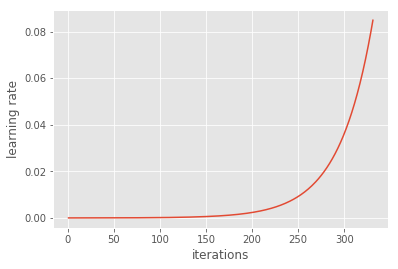

In [20]:
learner.sched.plot_lr()

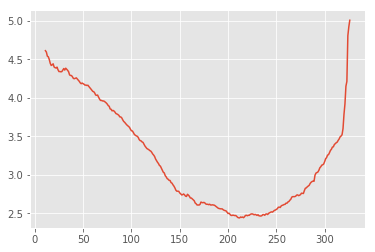

In [21]:
learner.sched.plot_loss()

In [10]:
learner.fit(lrs=0.001, n_cycle=3, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      2.480852   4.074373   0.090845  
    1      2.199589   3.799305   0.13662                    
    2      2.010273   3.394446   0.161972                   



[array([3.39445]), 0.1619718309859155]

In [7]:
trimmed_xs = [librosa.effects.trim(x[0])[0] for x in xs]
trimmed_xs = [file.reshape(1, file.shape[0]) for file in trimmed_xs]
xs = trimmed_xs

In [8]:
md_trimmed = AudioModelData.from_array(xs,ys, bs=24)

In [9]:
learner_trimmed = md_trimmed.get_model()

In [16]:
learner_trimmed.fit(lrs=0.001, n_cycle=10, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      3.297386   3.215609   0.122535  
    1      2.894773   2.881623   0.239437                   
    2      2.513907   2.482352   0.305634                   
    3      2.274101   2.445475   0.344366                   
    4      2.172393   2.126512   0.438732                   
    5      1.98806    2.130189   0.430282                   
    6      1.876554   2.120171   0.439437                   
    7      1.851672   1.992615   0.466197                   
    8      1.758893   1.871196   0.490141                   
    9      1.70636    1.80905    0.522535                   



[array([1.80905]), 0.5225352120231574]

In [16]:
learner_trimmed.save("base_35_ep")

In [10]:
learner_trimmed.load("base_35_ep")

In [15]:
learner_trimmed.fit(lrs=0.001, n_cycle=10, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      1.143386   1.604731   0.627465  
    1      1.128114   1.70371    0.612676                   
    2      1.176936   1.663222   0.607746                   
    3      1.071632   1.613879   0.63169                    
    4      1.02706    1.593437   0.643662                   
    5      1.087371   1.722438   0.621127                    
    6      1.003911   1.596032   0.642254                    
    7      0.956821   1.657607   0.643662                    
    8      1.011259   1.622717   0.646479                    
    9      0.976065   1.734534   0.633099                    



[array([1.73453]), 0.633098588359188]